# Classification of Breast Cancer Severity

In this report I'm going to analyze the **UCI ML Breast Cancer Wisconsin** dataset provided in Python's scikit learn library as one of the toy datasets.

This dataset was created with the help of 569 patients with breast cancer who underwent the FNA procedure. The procedure, used for lumps investigation, involves inserting a needle into the lump in order to analyze the cells inside it. Having digitized images of those **cells**, the authors of dataset defined **30 numerical features to describe them** in order to **predict the severity of breast cancer**. Severity is expressed as **2 classes discriminating between benign and malignant cancer**.

Source: [Sci-Kit Learn Documentation](https://scikit-learn.org/stable/datasets/toy_dataset.html#breast-cancer-dataset)

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.datasets import load_breast_cancer
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix

from matplotlib import pyplot as plt
from matplotlib.lines import Line2D

import pandas as pd
import seaborn as sns
import numpy as np

import xgboost

In [3]:
np.random.seed(1)

First thing I do after loading the data is a normalisation step. I opted for using min-max normalisation due to the fact that:
- I do not assume (or know) anything about distributions of specific features,
- some classification algorithms that I'm planning to use are prone to high values' differences.

In [4]:
data = load_breast_cancer(as_frame=True)
data, target = data["data"], data["target"]
data = (data - data.min(axis=0)) / (data.max(axis=0) - data.min(axis=0))

In [5]:
data.columns

Index(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error', 'fractal dimension error',
       'worst radius', 'worst texture', 'worst perimeter', 'worst area',
       'worst smoothness', 'worst compactness', 'worst concavity',
       'worst concave points', 'worst symmetry', 'worst fractal dimension'],
      dtype='object')

There are 30 features in the dataset, so, due to the fact I don't have any domain knowledge, I decided to perform feature selection analysis to reduce their number to make it more understandable. My criterion will be purely numerical and I'm going to analyze the contribution of each class towards the cancer discrimination.

However, one particular thing we can observe from the variables naming is the fact that:
- we have 3 types of feature measurement (mean, error, worst),
- we have (in principal) 10 major features (radius, texture, perimeter, area, smoothness, compactness, concavity, concave points, symmetry and fractal dimension).

This observation may lead us to hypothesis that there's a high chance of highly correlated variables in our dataset.

In [6]:
target.value_counts(normalize=True).apply(lambda x: round(x * 100, 2))

1    62.74
0    37.26
Name: target, dtype: float64

Due to the fact the data come from medical domain, I'm checking for a potential imbalance within a target variable. The ratio of classes is 3:2 and, due to the fact it's relatively small, I decided to ignore this slight imbalance.

Also, based on classes proportion and the knowledge from dataset documentation, I will further assume that classes will be assigned as:
- 0 - malignant tumor (meaning the patient condition is bad),
- 1 - benign tumor (meaning the patient condition is relatively good).

Additionally I checked for potential null values in the dataset, but none were found.

In [7]:
data.isnull().values.any()

False

For measuring model performance, I decided to use 10-fold cross validation. However, as I'm planning to firstly test some hypotheses regarding feature importance, I decided to choose 10% of the dataset at random for doing so.

This is because I could either:
- test hypotheses for each fold - which sounds a bit cumbersome in this particular example,
- test hypotheses for the whole data - but then I would make assumptions based on data that would be further used for testing (which is considered bad practice).

The 10% sample used for hypotheses testing will be used only for that and discarded in further cross validation setup. I also make sure that target distibution in this sample is the same as in the whole dataset.

In [8]:
target_hypothesis = target.sample(frac=0.1)
data_hypothesis = data[data.index.isin(target_hypothesis.index)]
data = data.drop(index=target_hypothesis.index)
target = target.drop(index=target_hypothesis.index)

In [9]:
print(target_hypothesis.value_counts(normalize=True).apply(lambda x: round(x * 100, 2)))
print(f"Train size: {len(data)}")
assert len(data) == len(target)
print(f"Hypothesis size: {len(data_hypothesis)}")
assert len(data_hypothesis) == len(target_hypothesis)

1    59.65
0    40.35
Name: target, dtype: float64
Train size: 512
Hypothesis size: 57


## Feature selection

My first intuition is to plot the dataset in a lower dimensional space using Principal Component Analysis transformation.

In [10]:
pca = PCA(n_components=2)
reduced_data_hypothesis = pca.fit_transform(data_hypothesis)

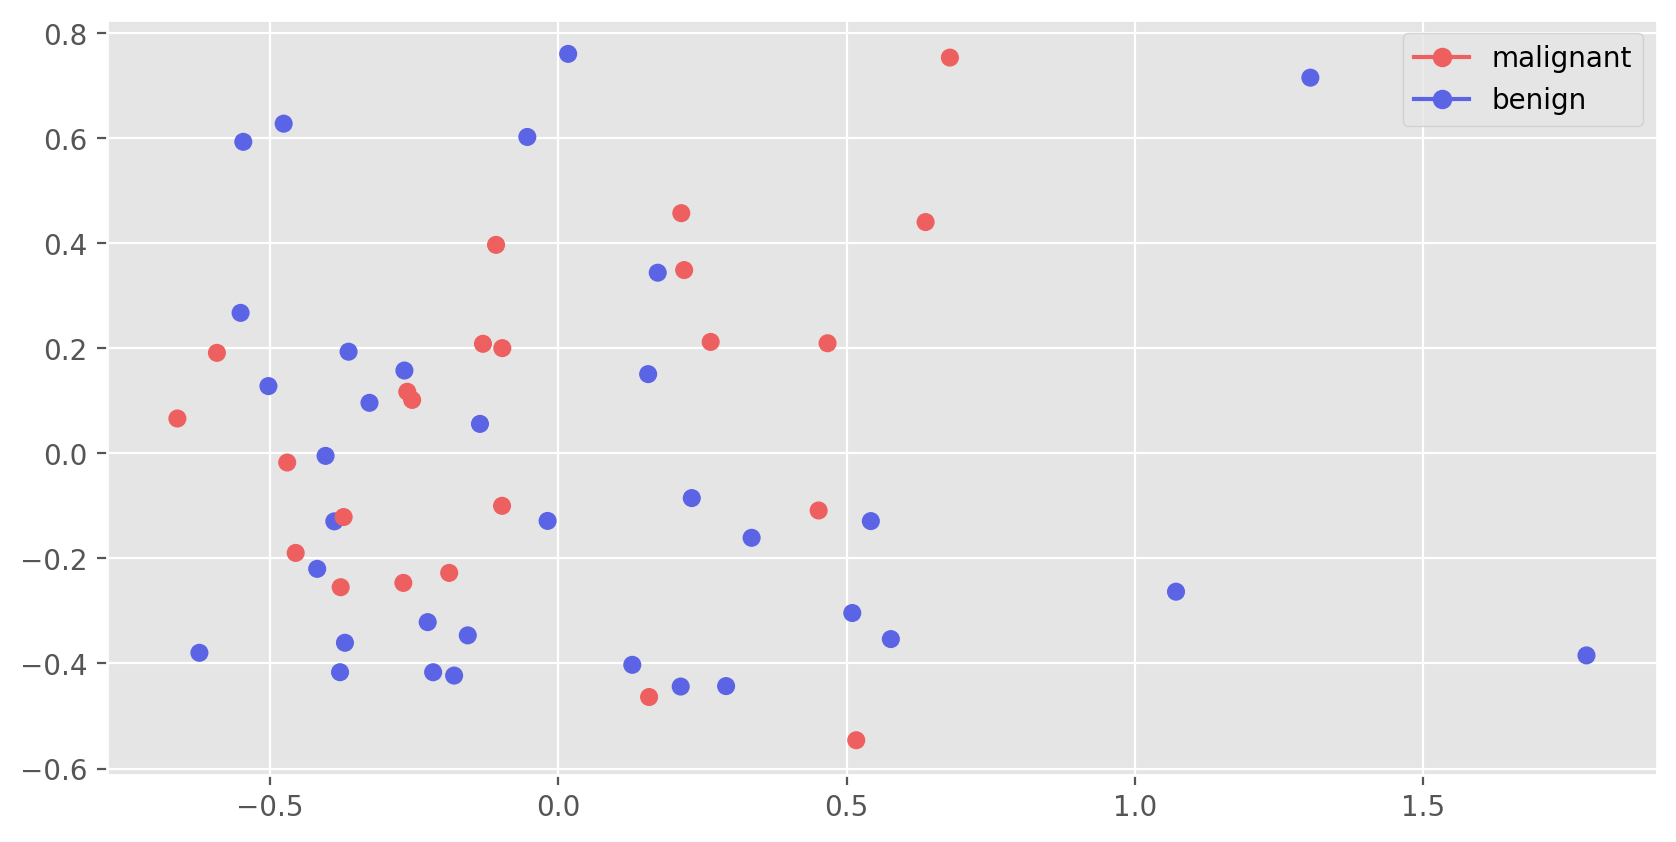

In [11]:
plt.style.use("ggplot")
plt.figure(figsize=(10, 5), dpi=200)
plt.scatter(*reduced_data_hypothesis.T, c=target_hypothesis.apply(lambda x: "#EE6060" if x == 0 else "#5A64E5"))

legend_elements = [Line2D([0], [0], marker='o', color='#EE6060', label='malignant'),
                   Line2D([0], [0], marker='o', color='#5A64E5', label='benign')]
plt.legend(handles=legend_elements)

We can already see that some of malignant cases resemble benign ones. This is why we should later properly choose performance metric for our model, due to the fact that there's a higher risk in predicting malignant tumor as benign instead of other way round.

For assessing feature redundancy with respect to target variable I decided to use a mutual information measure, which would measure the dependence between each feature and target variable. I decided to use it as something more general than simple correlation.

Firstly, I remove all features which show zero dependence with target variable.

In [12]:
mutual_information = mutual_info_classif(data_hypothesis, target_hypothesis, copy=True)
new_columns = [column for idx, column in enumerate(data.columns) if mutual_information[idx] > 0]

print(f"Columns reduced from {len(data.columns)} to {len(new_columns)}.")

data = data[new_columns]
data_hypothesis = data_hypothesis[new_columns]

Columns reduced from 30 to 19.


For identification of redundancy between features I decided to use simple correlation, because I hypothesize that we might find linear relations between features that are in a sense proportionate to each other (like radius and area of cells).

<AxesSubplot:>

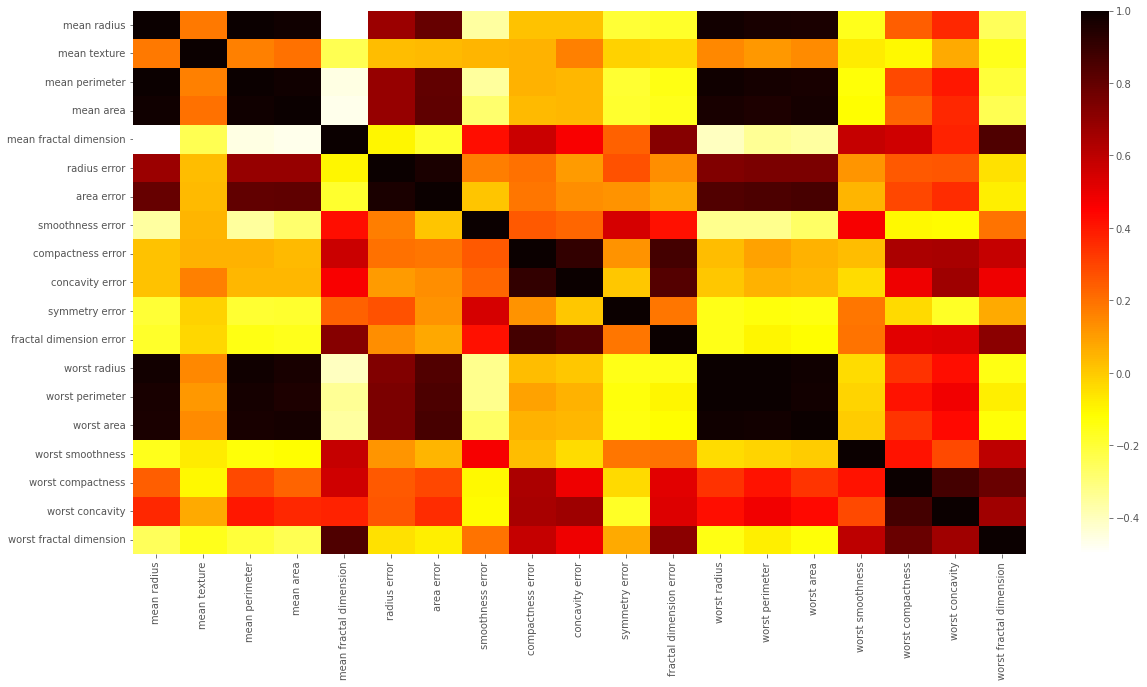

In [13]:
fig, ax = plt.subplots(figsize=(20,10))
sns.heatmap(data_hypothesis.corr(), ax=ax, cmap="hot_r")

We can easily notice some strong correlations between variables (significant ones lie outside of diagonal). I decided to exclude the variables further in a following manner:
- check which variables have high correlation (within clusters of them, so not necessarily pair-wise),
- choose 1 within a cluster which has highest mutual information with target variable.

Based on the heatmap we can identify following groups of high correlation:
- mean/worst radius/perimeter/area (6 variables),
- radius/area error (2 variables),
- worst compactness/concavity (2 variables),
- compactness/concavity error (2 variables).

In [14]:
mutual_information = mutual_info_classif(data_hypothesis, target_hypothesis, copy=True)

# mean/worst radius/perimeter/area cluster
print(mutual_information[[0, 2, 3, 12, 13, 14]])

# radius/area error
print(mutual_information[[5, 6]])

# worst compactness/concavity
print(mutual_information[[16, 17]])

# compactness/concavity error
print(mutual_information[[8, 9]])

[0.07403964 0.11612742 0.05178324 0.07194096 0.04541719 0.04084934]
[0.0377241  0.01489493]
[0.0167831  0.00310979]
[0.05054783 0.01993595]


In [15]:
to_drop = ["mean area", "mean radius", "worst area", "worst radius", "worst perimeter", "area error", "worst concavity", "concavity error"]

print(f"Columns reduced from {len(data.columns)} to {len(data.columns) - len(to_drop)}.")

data = data.drop(columns=to_drop)
data_hypothesis = data_hypothesis.drop(columns=to_drop)

Columns reduced from 19 to 11.


Last but not least, based on values of mutual information, I decided to exclude variables with less than 0.02 MI as something which, in my opinion, would not contribute in any way to the models.

In [16]:
mutual_information = mutual_info_classif(data_hypothesis, target_hypothesis, copy=True)
new_columns = [column for idx, column in enumerate(data.columns) if mutual_information[idx] > 0.02]

print(f"Columns reduced from {len(data.columns)} to {len(new_columns)}.")

data = data[new_columns]
data_hypothesis = data_hypothesis[new_columns]

Columns reduced from 11 to 8.


The following procedure reduces number of features from 30 to 8 which, in my opinion, increases the understanding/readability of the models (especially those that have intuitive interpretation coming from the model structure).

In [17]:
data.columns

Index(['mean texture', 'mean perimeter', 'radius error', 'smoothness error',
       'compactness error', 'symmetry error', 'fractal dimension error',
       'worst smoothness'],
      dtype='object')

The features that will be taken into account in the analysis will be (mean/worst/error is calculated based on all cells in a FNA image):
- texture (mean) - gray-scale deviation of a cell (averaged from couple of points within a cell),
- perimeter (mean) - perimeter of a cell,
- radius (error) - radius of a cell (averaged from couple of points within the cell),
- smoothness (error, worst) - radius variations within a cell,
- compactness (error) - perimeter/area based formula,
- symmetry (error) - symmetry of a cell,
- fractal dimension (error) - fractal-based measure of perimeter.

In [18]:
data = data.reset_index(drop=True)
target = target.reset_index(drop=True)

## Models

For 3 distinctive models I decided to use: Logistic Regression, XGBoost and Multi-Layered Perceptron (MLP).

As mentioned above, for performance measurement I will be using 10-fold Cross Validation. I create the division firstly to make sure the same folds are used in all trainings.

In [19]:
skf = StratifiedKFold(n_splits=10)

for train_index, test_index in skf.split(data, target):
    print("TRAIN:", len(train_index), "TEST:", len(test_index))

TRAIN: 460 TEST: 52
TRAIN: 460 TEST: 52
TRAIN: 461 TEST: 51
TRAIN: 461 TEST: 51
TRAIN: 461 TEST: 51
TRAIN: 461 TEST: 51
TRAIN: 461 TEST: 51
TRAIN: 461 TEST: 51
TRAIN: 461 TEST: 51
TRAIN: 461 TEST: 51


For measuring model performance, I decided to use 3 metrics:
- F1 score - which would reduce the problem of slight imbalance that we have when calculating metrics (the higher, the better),
- AUC score - which tells us how capable model is of distinguishing between malignant and benign tumor (the higher, the better),
- False Positive Rate - which would tell us how many malignant cases we actually predict as benign (the lower, the better).

First 2 metrics are available in Sci-Kit package, while the third one I implement on my own. 

I also create metrics placeholders for further analysis.

In [20]:
def fpr_score(y_true, y_pred):
  tn, fp, _, _ = confusion_matrix(y_true, y_pred).ravel()
  return fp / (fp + tn)

In [21]:
fpr = {"logistic regression": [], "xgboost": [], "mlp": []}
f1 = {"logistic regression": [], "xgboost": [], "mlp": []}
auc = {"logistic regression": [], "xgboost": [], "mlp": []}

Below, for each type of model, I perform exactly the same procedure:
- I train each type on each of 10 folds,
- I do not tune any of the types (I use default model),
- I save results of all 3 metrics for each fold.

### Logistic regression

In [22]:
for train_index, test_index in skf.split(data, target):

    data_train, data_test = data.loc[train_index], data.loc[test_index]
    target_train, target_test = target.loc[train_index], target.loc[test_index]

    log_reg = LogisticRegression(max_iter=1e3).fit(data_train, target_train)
    prediction_test = log_reg.predict(data_test)
    proba_test = log_reg.predict_proba(data_test)[:, 1]

    auc["logistic regression"].append(roc_auc_score(target_test, proba_test))
    fpr["logistic regression"].append(fpr_score(target_test, prediction_test))
    f1["logistic regression"].append(f1_score(target_test, prediction_test))

### XGBoost

In [23]:
for train_index, test_index in skf.split(data, target):

    data_train, data_test = data.loc[train_index], data.loc[test_index]
    target_train, target_test = target.loc[train_index], target.loc[test_index]

    xgboost_model = xgboost.XGBClassifier(use_label_encoder=False, eval_metric="logloss").fit(data_train, target_train)
    prediction_test = xgboost_model.predict(data_test)
    proba_test = xgboost_model.predict_proba(data_test)[:, 1]

    auc["xgboost"].append(roc_auc_score(target_test, proba_test))
    fpr["xgboost"].append(fpr_score(target_test, prediction_test))
    f1["xgboost"].append(f1_score(target_test, prediction_test))

### MLP

In [24]:
for train_index, test_index in skf.split(data, target):

    data_train, data_test = data.loc[train_index], data.loc[test_index]
    target_train, target_test = target.loc[train_index], target.loc[test_index]

    mlp = MLPClassifier(max_iter=1000).fit(data_train, target_train)
    prediction_test = mlp.predict(data_test)
    proba_test = mlp.predict_proba(data_test)[:, 1]

    auc["mlp"].append(roc_auc_score(target_test, proba_test))
    fpr["mlp"].append(fpr_score(target_test, prediction_test))
    f1["mlp"].append(f1_score(target_test, prediction_test))

## Performance analysis

I decided to compare models with respect to each metric using 2 types of plots:
- box plot - to see the metric distribution based on all 10 folds,
- bar plot - to see the final metric within each fold.

I also analyse metric value averaged from all folds.

In [25]:
fpr = pd.DataFrame(fpr)

fpr.mean(axis=0)

logistic regression    0.195322
xgboost                0.084503
mlp                    0.057895
dtype: float64

The averaged score would suggest that default MLP performs the best in terms of False Positive Rate - let's see if the plots confirm this.

<AxesSubplot:>

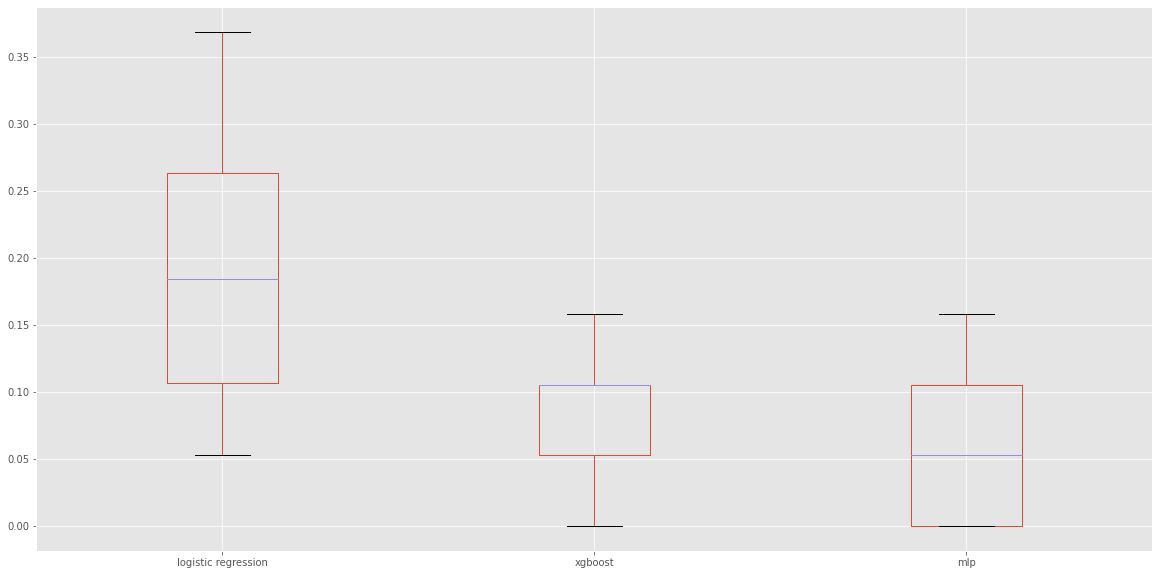

In [26]:
fpr.boxplot(figsize=(20, 10))

In terms of FPR, our Logistic Regression model performs the worst - there are folds in which more than 35% of malignant cases are classified as benign. Between XGBoost and MLP, XGBoost seem to have smaller score variability between the folds. MLP on the other hand tend to have smaller FPR value in some of the folds - the both have a similar worst case scenario though.

<AxesSubplot:>

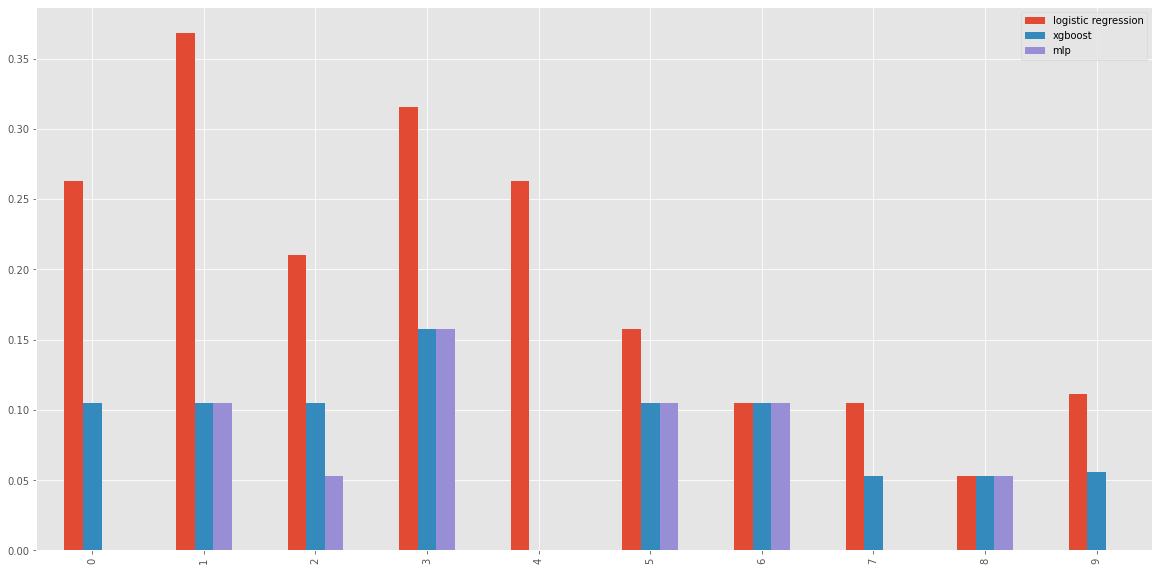

In [27]:
fpr.plot.bar(figsize=(20, 10))

Further with the bar plot we can additionaly see that MLP achieves a perfect score in 4 out of 10 folds in terms of FPR (in comparison to 1 for XGBoost), which would again make MLP safer to use in the medical setup.

Next we analyze AUC.

In [28]:
auc = pd.DataFrame(auc)

auc.mean(axis=0)

logistic regression    0.987378
xgboost                0.984785
mlp                    0.984897
dtype: float64

In the averaged case, AUC score does not tell us much - all models seem to have a good discrimination capabilities.

<AxesSubplot:>

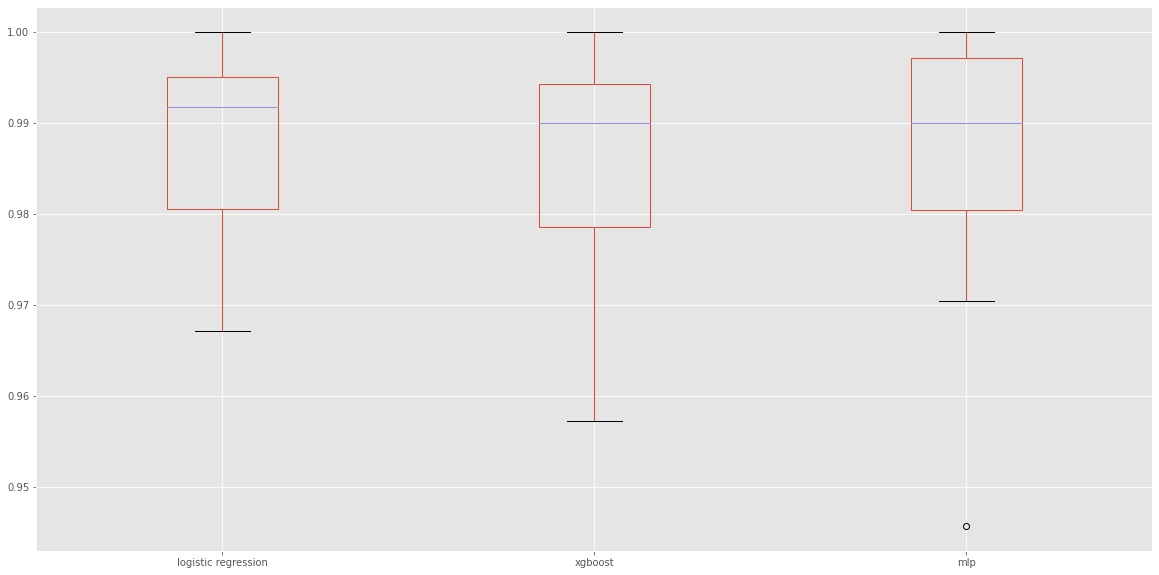

In [29]:
auc.boxplot(figsize=(20, 10))

Similarly in the box plot, if we look at values on y axis, models seem not to differ that much. However, MLP tend to have higher values, although Logistic Regression seems to have smaller variability between folds, which could explain its better performance with this metric. There was no particular addition to AUC interpretation when using a bar plot, so I decided to skip it.

In [30]:
f1 = pd.DataFrame(f1)

f1.mean(axis=0)

logistic regression    0.941954
xgboost                0.959971
mlp                    0.967571
dtype: float64

F1 averaged across folds suggest us that again MLP scores the highest among all models.

<AxesSubplot:>

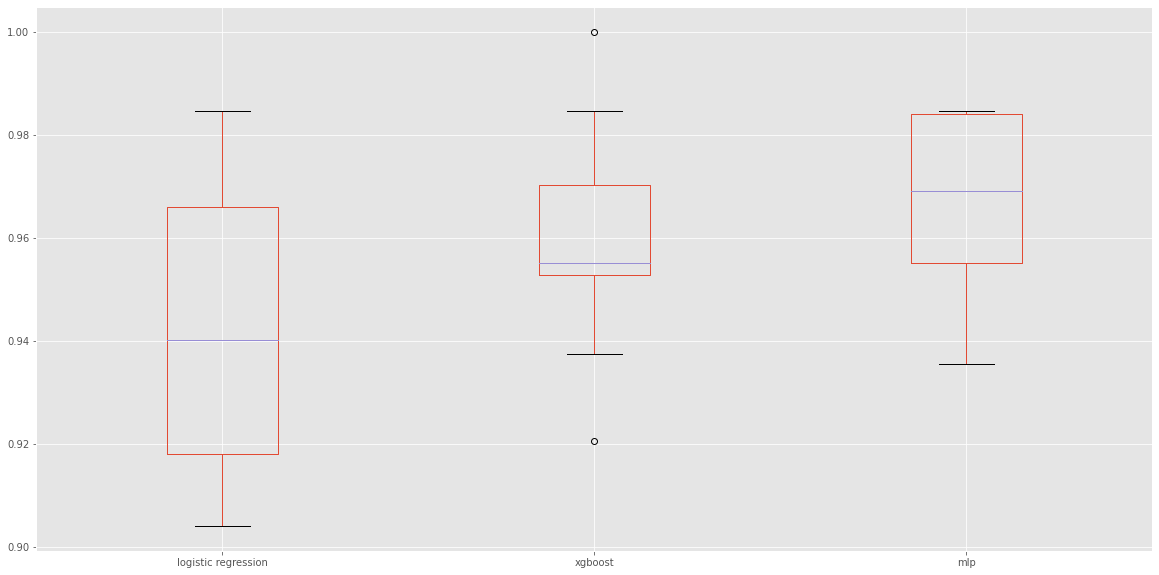

In [31]:
f1.boxplot(figsize=(20, 10))

Box plots additionaly explain why - MLP tends to have higher values of F1 in folds and it also has the highest minimum value of F1 for all folds (note outliers in XGBoost). However, XGBoost have some folds achieving a perfect F1 score which could be worth inspecting in case of potential models tuning. Similarly to AUC, bar plot that I decided to use previously does not provide any substantial addition to this interpretation.

## Closing remarks

Based on FPR and F1 analysis for those particular models, MLP seems to have the best performance - both in terms of general predictive power and reducing the risk of classifying a malignant tumor as benign. However, the FPR is yet to be reduced to the acceptable levels and could be used further as a leading metric for assessing model performance.

Also, the discrepancies between the models could be a result of a chosen feature selection procedure - there is still a chance that models could contribute from the removed variables, so further work could include checking how models behave having a full information or removing features based on particular measure of model performance.

Finally, the models were in its default state - meaning that there might actually be a benefit with procedures like hyperparameters tuning to increase their performance. Moreover, due to the fact that data is small and tabular, we could also use some simple AutoML techniques to find the best model instead of trying to engineer one and focus more on understanding the underlying data.